# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

Using: cuda


# CIFAR-100 for self-supervision

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 47.7MB/s]


# Masked Patch Embedding

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self,img_size=32,patch_size=4,in_ch=3,embed_dim=256):
    super().__init__()
    self.patch_size=patch_size
    self.num_patches=(img_size//patch_size)**2
    self.proj=nn.Conv2d(in_ch,embed_dim,kernel_size=patch_size,stride=patch_size)
    self.pos_embed=nn.Parameter(torch.zeros(1,self.num_patches,embed_dim))
    self.mask_token=nn.Parameter(torch.zeros(1,1,embed_dim))

  def forward (self,x,mask=None):
    B=x.shape[0]
    x=self.proj(x).flatten(2).transpose(1,2)
    x=x+self.pos_embed

    if mask is not None:
      mask_token=self.mask_token.expand(B,x.size(1),-1)
      x=torch.where(mask.unsqueeze(-1).bool(),mask_token,x)
    return x

# Multi-Head Self Attention

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.out(out)

# Transformer Encoder

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Masked ViT for Patch Reconstruction

In [ ]:
class MaskedViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, embed_dim=256, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, 3, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        self.head = nn.Linear(embed_dim, 3 * (patch_size ** 2))  # reconstruct RGB patch

    def forward(self, x, mask):
        x = self.patch_embed(x, mask)
        x = self.encoder(x)
        return self.head(x)  # (B, N, 3*P^2)

# Generating Random Mask

In [ ]:
def random_mask(batch_size, num_patches, mask_ratio=0.5):
    mask = torch.rand(batch_size, num_patches, device=DEVICE)
    mask = mask < mask_ratio
    return mask


# Pretraining Loop

In [ ]:
model = MaskedViT().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, _ in trainloader:
        x = x.to(DEVICE)
        B = x.shape[0]
        mask = random_mask(B, model.patch_embed.num_patches)

        # Forward
        pred = model(x, mask)  # (B, N, patch_dim)

        # Create patch targets directly from image
        patch_size = model.patch_embed.patch_size
        target = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        target = target.contiguous().view(B, 3, -1, patch_size, patch_size)
        target = target.permute(0, 2, 1, 3, 4).flatten(2)  # (B, N, 3*P^2)

        # Compute loss on masked patches only
        loss = criterion(pred[mask], target[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {total_loss/len(trainloader):.4f}")


Epoch [1/10]  Loss: 0.0506
Epoch [2/10]  Loss: 0.0439
Epoch [3/10]  Loss: 0.0437
Epoch [4/10]  Loss: 0.0437
Epoch [5/10]  Loss: 0.0435
Epoch [6/10]  Loss: 0.0435
Epoch [7/10]  Loss: 0.0436
Epoch [8/10]  Loss: 0.0435
Epoch [9/10]  Loss: 0.0435
Epoch [10/10]  Loss: 0.0435


In [ ]:
# Save pretrained encoder
torch.save(model.state_dict(), "masked_vit_pretrained.pth")


# Freeze Encoder and training the Linear Classifier

In [ ]:
class LinearProbe(nn.Module):
  def __init__(self,encoder,embed_dim=256,num_classes=100):
    super().__init__()
    self.encoder=encoder
    for p in self.encoder.parameters():
      p.requires_grad=False
    self.norm=nn.LayerNorm(embed_dim)
    self.fc=nn.Linear(embed_dim,num_classes)

  def forward(self,x):
    with torch.no_grad():
      patches=self.encoder.patch_embed(x)
      features=self.encoder.encoder(patches)
      x=features.mean(dim=1)
    x=self.norm(x)
    return self.fc(x)

probe = LinearProbe(model,embed_dim=256,num_classes=100).to(DEVICE)
optimizer=torch.optim.Adam(probe.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()

for epoch in range(5):
  probe.train()
  correct,total,total_loss=0,0,0
  for x,y in trainloader:
    x,y=x.to(DEVICE),y.to(DEVICE)
    out=probe(x)
    loss=criterion(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
    correct+= (out.argmax(1)==y).sum().item()
    total+=y.size(0)
  acc=correct/total
  print(f"[Probe Epoch {epoch+1}/5]  Loss: {total_loss/len(trainloader):.4f}  Acc: {acc:.4f}")


[Probe Epoch 1/5]  Loss: 4.3111  Acc: 0.0472
[Probe Epoch 2/5]  Loss: 4.2055  Acc: 0.0586
[Probe Epoch 3/5]  Loss: 4.1788  Acc: 0.0628
[Probe Epoch 4/5]  Loss: 4.1612  Acc: 0.0683
[Probe Epoch 5/5]  Loss: 4.1435  Acc: 0.0699


In [ ]:
class ViTClassifier(nn.Module):
    def __init__(self, pretrained_vit, num_classes=100):
        super().__init__()
        self.encoder = pretrained_vit.encoder
        self.patch_embed = pretrained_vit.patch_embed
        self.norm = nn.LayerNorm(256)
        self.head = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # global average pooling
        x = self.norm(x)
        return self.head(x)


In [ ]:

finetune_model = ViTClassifier(model, num_classes=100).to(DEVICE)

# Option A: Linear probe (freeze encoder)
#for p in finetune_model.encoder.parameters():
    #p.requires_grad = False

# Option B: Full fine-tuning
for p in finetune_model.encoder.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(finetune_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS_FT = 10
train_accs, test_accs = [], []

for epoch in range(EPOCHS_FT):
    finetune_model.train()
    correct, total, total_loss = 0, 0, 0
    for x, y in trainloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = finetune_model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    train_accs.append(train_acc)

    # ---- Evaluate on test set ----
    finetune_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = finetune_model(x)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    test_acc = correct / total
    test_accs.append(test_acc)

    print(f"[Fine-Tune {epoch+1}/{EPOCHS_FT}] TrainAcc={train_acc:.3f} TestAcc={test_acc:.3f}")


[Fine-Tune 1/10] TrainAcc=0.065 TestAcc=0.106
[Fine-Tune 2/10] TrainAcc=0.129 TestAcc=0.146
[Fine-Tune 3/10] TrainAcc=0.170 TestAcc=0.181
[Fine-Tune 4/10] TrainAcc=0.196 TestAcc=0.208
[Fine-Tune 5/10] TrainAcc=0.220 TestAcc=0.229
[Fine-Tune 6/10] TrainAcc=0.240 TestAcc=0.244
[Fine-Tune 7/10] TrainAcc=0.260 TestAcc=0.241
[Fine-Tune 8/10] TrainAcc=0.279 TestAcc=0.269
[Fine-Tune 9/10] TrainAcc=0.293 TestAcc=0.288
[Fine-Tune 10/10] TrainAcc=0.306 TestAcc=0.290


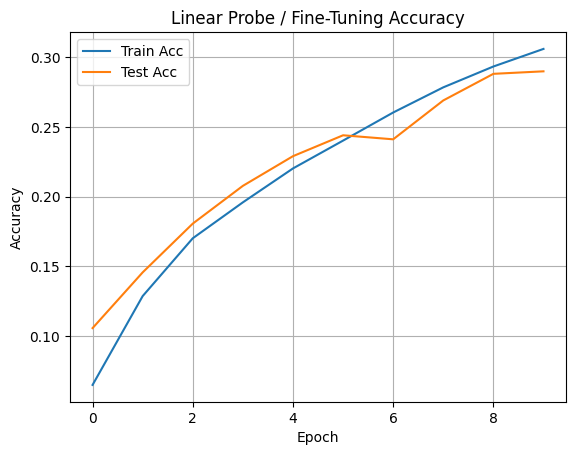

In [ ]:
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Linear Probe / Fine-Tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Visualization

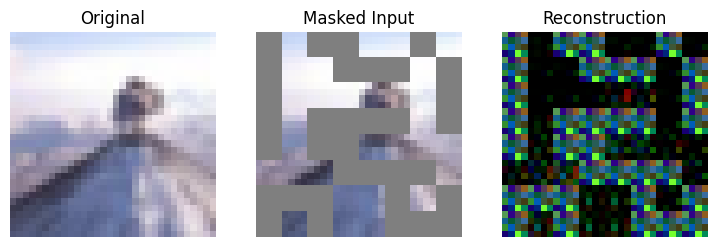

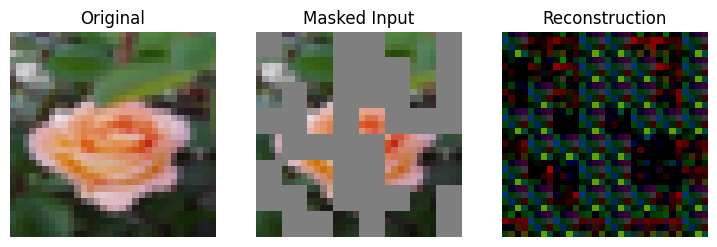

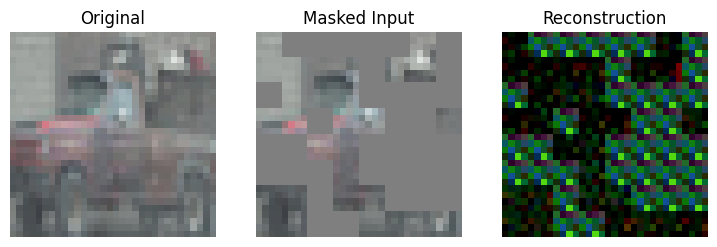

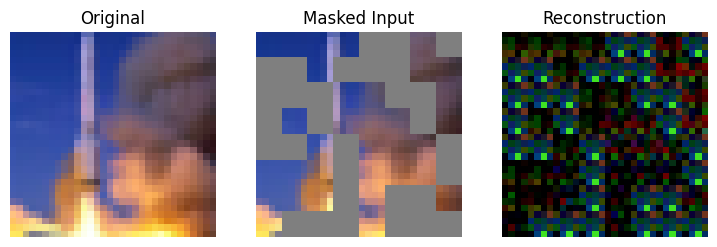

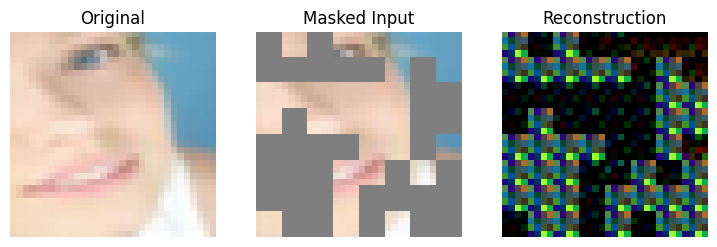

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

def visualize_masked_reconstruction(model, dataloader, mask_ratio=0.5, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(DEVICE)
            B = x.size(0)
            mask = random_mask(B, model.patch_embed.num_patches, mask_ratio=mask_ratio)
            pred = model(x, mask)

            patch_size = model.patch_embed.patch_size
            num_patches = model.patch_embed.num_patches
            h = w = int(num_patches ** 0.5)

            # Ground truth patches (unfolded image)
            target = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
            target = target.contiguous().view(B, 3, -1, patch_size, patch_size)
            target = target.permute(0, 2, 1, 3, 4).flatten(2)  # (B, N, 3*P^2)

            # Reconstruct image from predicted patches
            pred_img = torch.zeros_like(x)
            mask_np = mask[0].cpu().numpy().reshape(h, w)

            i = 0
            for y_pos in range(0, 32, patch_size):
                for x_pos in range(0, 32, patch_size):
                    patch = pred[0, i].detach().cpu().reshape(3, patch_size, patch_size)
                    pred_img[0, :, y_pos:y_pos+patch_size, x_pos:x_pos+patch_size] = patch
                    i += 1

            # Apply masking for visualization
            masked_img = x.clone()
            i = 0
            for y_pos in range(0, 32, patch_size):
                for x_pos in range(0, 32, patch_size):
                    if mask[0, i]:
                        masked_img[0, :, y_pos:y_pos+patch_size, x_pos:x_pos+patch_size] = 0.5
                    i += 1

            # Plot
            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(x[0].permute(1, 2, 0).cpu())
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masked_img[0].permute(1, 2, 0).cpu())
            plt.title("Masked Input")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_img[0].permute(1, 2, 0).cpu().clip(0, 1))
            plt.title("Reconstruction")
            plt.axis("off")

            plt.show()

            images_shown += 1
            if images_shown >= num_images:
                break


visualize_masked_reconstruction(model, testloader, mask_ratio=0.5, num_images=5)
